# 패키지 로딩

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Imputer #missing value를 처리
from sklearn.preprocessing import PolynomialFeatures #interaction 변수를 만들어줌
from sklearn.preprocessing import StandardScaler #평균을 0, 분산을 1
from sklearn.feature_selection import VarianceThreshold #기본적으로 분산이 0인 피처를 제거 할 수 있음
from sklearn.feature_selection import SelectFromModel #피처 중요도에 따라 피처를 선택
from sklearn.utils import shuffle #오버,언더샘플링에 사용
from sklearn.ensemble import RandomForestClassifier

pd.set_option("display.max_columns", 100)

In [47]:
import warnings
warnings.filterwarnings('ignore')

# 데이터 로딩

In [48]:
DEBUG = True #True면 일부, False면 모든 데이터

In [49]:
if DEBUG: #최소한의 데이터를 가지고 실험일 땐 
    NROWS = 50000
else:     #실제 결과를 낼 땐 모두 사용
    NROWS = None

In [50]:
%%time
train = pd.read_csv('../input/porto-seguro-safe-driver-prediction/train.csv',nrows=NROWS)
test = pd.read_csv('../input/porto-seguro-safe-driver-prediction/test.csv',nrows=NROWS)
train = train.sample(frac=1) #frac은 데이터를 가져오는 비율

CPU times: user 488 ms, sys: 16 ms, total: 504 ms
Wall time: 503 ms


In [51]:
train.shape #데이터를 알맞게 가져왔는지 확인

(50000, 59)

In [52]:
train.info() #각 컬럼의 이름, 수, null, 타입을 알려줌

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 26170 to 25409
Data columns (total 59 columns):
id                50000 non-null int64
target            50000 non-null int64
ps_ind_01         50000 non-null int64
ps_ind_02_cat     50000 non-null int64
ps_ind_03         50000 non-null int64
ps_ind_04_cat     50000 non-null int64
ps_ind_05_cat     50000 non-null int64
ps_ind_06_bin     50000 non-null int64
ps_ind_07_bin     50000 non-null int64
ps_ind_08_bin     50000 non-null int64
ps_ind_09_bin     50000 non-null int64
ps_ind_10_bin     50000 non-null int64
ps_ind_11_bin     50000 non-null int64
ps_ind_12_bin     50000 non-null int64
ps_ind_13_bin     50000 non-null int64
ps_ind_14         50000 non-null int64
ps_ind_15         50000 non-null int64
ps_ind_16_bin     50000 non-null int64
ps_ind_17_bin     50000 non-null int64
ps_ind_18_bin     50000 non-null int64
ps_reg_01         50000 non-null float64
ps_reg_02         50000 non-null float64
ps_reg_03         50000 n

# 메타 데이터

* 데이터 관리를 쉽게 하기 위해 변수에 대한 메타 정보를 데이터프레임에 저장.
* 분석, 시각화, 모델링을 위해 특정 변수를 선택하고자 할 때 도움이 됨.

In [53]:
data = []
for f in train.columns:
    #role 정의
    if f =='target':
        role = 'target'
    elif f == 'id':
        role = 'id'
    else:
        role = 'input'
    
    #level 정의
    if 'bin' in f or f == 'target':
        level = 'binary'
    elif 'cat' in f or f == 'id':
        level = 'nominal'
    elif train[f].dtype == float:
        level = 'interval'
    elif train[f].dtype == int:
        level = 'ordinal'
        
    #id를 제외한 모든 변수를 Ture로 초기화
    keep = True
    if f == 'id':
        keep = False
    
    # 데이터 유형 정의
    dtype = train[f].dtype
    
    # 변수에 대한 메타 데이터를 담는 사전 만들기
    f_dict = {
        'varname': f,
        'role': role,
        'level': level,
        'keep': keep,
        'dtype': dtype
    }
    data.append(f_dict)

meta = pd.DataFrame(data, columns=['varname','role','level','keep','dtype'])
#리스트를 데이터프레임으로 저장
meta.set_index('varname', inplace=True)
#인덱스를 'varname'으로 지정

In [54]:
meta

,role,level,keep,dtype
varname,,,,
id,id,nominal,False,int64
target,target,binary,True,int64
ps_ind_01,input,ordinal,True,int64
ps_ind_02_cat,input,nominal,True,int64
ps_ind_03,input,ordinal,True,int64
ps_ind_04_cat,input,nominal,True,int64
ps_ind_05_cat,input,nominal,True,int64
ps_ind_06_bin,input,binary,True,int64
ps_ind_07_bin,input,binary,True,int64


In [55]:
pd.DataFrame({'count':meta.groupby(['role','level'])['role'].size()}).reset_index()
#role 및 level 당 변수의 개수 출력 예제

,role,level,count
0,id,nominal,1
1,input,binary,17
2,input,interval,10
3,input,nominal,14
4,input,ordinal,16
5,target,binary,1


# 기술 통계(Descriptive statistics)

* 메타 파일 덕분에 기술 통계를 계산할 변수를 쉽게 선택할 수 있음.
* 데이터 유형마다 적용.

In [56]:
#Interval

v = meta[(meta.level == 'interval') & (meta.keep)].index
#meta 데이터를 만들 때 인덱스를 컬럼으로 만들었기 때문에 원하는 조건의 인덱스를 저장
train[v].describe()

,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,0.611218,0.440496,0.549395,0.379991,0.812831,0.276139,3.066712,0.450850,0.45047,0.450312
std,0.288885,0.402721,0.796278,0.058344,0.223336,0.357450,0.731320,0.287275,0.28675,0.287393
min,0.000000,0.000000,-1.000000,0.141421,0.313241,-1.000000,0.000000,0.000000,0.00000,0.000000
25%,0.400000,0.200000,0.523211,0.316228,0.671725,0.332265,2.828427,0.200000,0.20000,0.200000
50%,0.700000,0.300000,0.721976,0.374166,0.765811,0.368782,3.316625,0.500000,0.50000,0.500000
75%,0.900000,0.600000,1.004054,0.400000,0.905584,0.397492,3.605551,0.700000,0.70000,0.700000
max,0.900000,1.800000,3.197753,1.264911,2.707275,0.636396,3.741657,0.900000,0.90000,0.900000


In [57]:
#Ordinal

v = meta[(meta.level == 'ordinal') & (meta.keep)].index
#meta 데이터를 만들 때 인덱스를 컬럼으로 만들었기 때문에 원하는 조건의 인덱스를 저장
train[v].describe()

,ps_ind_01,ps_ind_03,ps_ind_14,ps_ind_15,ps_car_11,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000
mean,1.899340,4.412180,0.012720,7.292820,2.344160,2.370620,1.889280,7.691100,2.991960,9.218340,2.340100,8.418020,5.459980,1.443660,2.873440,7.53192
std,1.986335,2.695194,0.128213,3.549272,0.833647,1.118233,1.141108,1.337668,1.410438,1.462816,1.247407,2.895695,2.344992,1.202953,1.687412,2.75090
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,0.000000,2.000000,0.000000,5.000000,2.000000,2.000000,1.000000,7.000000,2.000000,8.000000,1.000000,6.000000,4.000000,1.000000,2.000000,6.00000
50%,1.000000,4.000000,0.000000,7.000000,3.000000,2.000000,2.000000,8.000000,3.000000,9.000000,2.000000,8.000000,5.000000,1.000000,3.000000,7.00000
75%,3.000000,6.000000,0.000000,10.000000,3.000000,3.000000,3.000000,9.000000,4.000000,10.000000,3.000000,10.000000,7.000000,2.000000,4.000000,9.00000
max,7.000000,11.000000,3.000000,13.000000,3.000000,5.000000,6.000000,10.000000,9.000000,12.000000,7.000000,22.000000,19.000000,9.000000,12.000000,22.00000


In [58]:
#Binary

v = meta[(meta.level == 'binary') & (meta.keep)].index
#meta 데이터를 만들 때 인덱스를 컬럼으로 만들었기 때문에 원하는 조건의 인덱스를 저장
train[v].describe()

,target,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.00000,50000.000000
mean,0.036660,0.393880,0.255340,0.16410,0.186680,0.000400,0.001860,0.00964,0.000820,0.662060,0.120100,0.151800,0.123280,0.630300,0.556040,0.288840,0.35136,0.153840
std,0.187928,0.488614,0.436057,0.37037,0.389658,0.019996,0.043088,0.09771,0.028624,0.473013,0.325082,0.358831,0.328762,0.482728,0.496855,0.453228,0.47740,0.360799
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.00000,0.000000
75%,0.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.00000,0.000000
max,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


# 불균형 클래스 다루기

* target=1인 레코드의 비율은 target=0인 레코드 보다 현저히 적다.
* 이 문제를 해결할 수 있는 두 가지의 전략
 * target=1 레코드를 오버샘플링
 * target=0 레코드를 언더샘플링
* !물론 더 많은 전략이 있다

In [59]:
desired_apriori = 0.10

idx_0 = train[train.target == 0].index
idx_1 = train[train.target == 1].index
#타겟의 값에 따라 인덱스를 가져온다

nb_0 = len(train.loc[idx_0])
nb_1 = len(train.loc[idx_1])
#target값이 0, 1을 가진 인덱스의 개수를 가져옴

undersampling_rate = ((1-desired_apriori)*nb_1)/(nb_0*desired_apriori)
#개수를 반영하여 rate를 측정
undersampled_nb_0 = int(undersampling_rate*nb_0)
print('Rate to undersample records with target = 0 : {}'.format(undersampling_rate))
print('Number of records with target=0 after undersampling : {}'.format(undersampled_nb_0))

undersampled_idx = shuffle(idx_0, random_state=37, n_samples=undersampled_nb_0)
#shuffle을 이용하여 undersampled_nb_0의 개수만 남기고 무작위로 선택하여 언더샘플된 인덱스를 구함

idx_list = list(undersampled_idx) + list(idx_1)
#target이 1인 인덱스와 언더샘플된 0인덱스를 합쳐 재구성

train = train.loc[idx_list].reset_index(drop=True)
#언더샘플링 데이터프레임을 반환

Rate to undersample records with target = 0 : 0.34249589968235516
Number of records with target=0 after undersampling : 16497


In [60]:
train['target'].value_counts()

0    16497
1     1833
Name: target, dtype: int64

# 데이터 품질 검사

* 누락된 값 검사(누락된 데이터는 -1로 표시되어 있음)

In [61]:
vars_with_missing = []

for f in train.columns:
    missings = train[train[f] == -1][f].count()
    #-1인 값을 찾음
    if missings > 0:
        vars_with_missing.append(f)
        missings_perc = missings / train.shape[0]
        #-1인 값과 전체 값을 나눠 perc를 구함 
        
        print('Variable {} has {} records ({:.2%}) with missing values'.format(f, missings, missings_perc))
print('In total, there are {} variables with missing values'.format(len(vars_with_missing)))    

Variable ps_ind_02_cat has 5 records (0.03%) with missing values
Variable ps_ind_04_cat has 3 records (0.02%) with missing values
Variable ps_ind_05_cat has 190 records (1.04%) with missing values
Variable ps_reg_03 has 3297 records (17.99%) with missing values
Variable ps_car_01_cat has 3 records (0.02%) with missing values
Variable ps_car_03_cat has 12643 records (68.97%) with missing values
Variable ps_car_05_cat has 8007 records (43.68%) with missing values
Variable ps_car_07_cat has 362 records (1.97%) with missing values
Variable ps_car_09_cat has 14 records (0.08%) with missing values
Variable ps_car_14 has 1304 records (7.11%) with missing values
In total, there are 10 variables with missing values


In [62]:
vars_to_drop = ['ps_car_03_cat','ps_car_05_cat']
train.drop(vars_to_drop, inplace=True, axis=1)
#누락 된 값이 너무 많은 변수를 제거
meta.loc[(vars_to_drop), 'keep'] = False
#메타 데이터 갱신

mean_imp = Imputer(missing_values=-1, strategy='mean', axis=0)
mode_imp = Imputer(missing_values=-1, strategy='most_frequent', axis=0)
#Imputer을 이용해 평균 혹은 비율이 높은 데이터로 대체

train['ps_reg_03'] = mean_imp.fit_transform(train[['ps_reg_03']]).ravel()
train['ps_car_12'] = mean_imp.fit_transform(train[['ps_car_12']]).ravel()
train['ps_car_14'] = mean_imp.fit_transform(train[['ps_car_14']]).ravel()
train['ps_car_11'] = mode_imp.fit_transform(train[['ps_car_11']]).ravel()
#fit_transform사용하여 적용

In [63]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print(v)
#원-핫 인코딩을 사용하려면 고유한 값이 적어야 컬럼을 덜 만든다.
for f in v:
    dist_values = train[f].value_counts().shape[0]
    #고유한 값, == .nunique()
    print('Variable {} has {} distinct values'.format(f, dist_values))

Index(['ps_ind_02_cat', 'ps_ind_04_cat', 'ps_ind_05_cat', 'ps_car_01_cat',
       'ps_car_02_cat', 'ps_car_04_cat', 'ps_car_06_cat', 'ps_car_07_cat',
       'ps_car_08_cat', 'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11_cat'],
      dtype='object', name='varname')
Variable ps_ind_02_cat has 5 distinct values
Variable ps_ind_04_cat has 3 distinct values
Variable ps_ind_05_cat has 8 distinct values
Variable ps_car_01_cat has 13 distinct values
Variable ps_car_02_cat has 2 distinct values
Variable ps_car_04_cat has 10 distinct values
Variable ps_car_06_cat has 18 distinct values
Variable ps_car_07_cat has 3 distinct values
Variable ps_car_08_cat has 2 distinct values
Variable ps_car_09_cat has 6 distinct values
Variable ps_car_10_cat has 3 distinct values
Variable ps_car_11_cat has 104 distinct values


* ps_car_11_cat의 값이 get_dummies하기엔 유니크한 값이 너무 많다
* mean encoding
* 카테고리의 수가 많으면 mean인코딩, frequency인코딩 사용
* 카테고리의 수가 적어도 mean인코딩, frequency인코딩의 성능이 더 좋다면 one-hot인코딩 대신 mean인코딩, frequency인코딩 사용

In [64]:
def add_noise(series, noise_level):
    return series * (1+noise_level*np.random.randn(len(series)))

def target_encode(trn_series=None,
                  tst_series=None,
                  target=None,
                  min_samples_leaf=1,
                  smoothing=1,
                  noise_level=0):
    '''
    trn_series : pd.Series 형태의 학습할 범주형 피처
    tst_series : pd.Series 형태의 테스트할 범주형 피처
    target : pd.Series 형태의 타겟 데이터
    min_samples_leaf (int) : 범주의 평균을 고려할 최소 샘플
    smoothing (int) : 범주 평균과 이전의 균형을 맞추기 위한 스무딩 효과
    '''
    assert len(trn_series) == len(target)
    assert trn_series.name == tst_series.name
    temp = pd.concat([trn_series, target], axis=1)
    averages = temp.groupby(by=trn_series.name)[target.name].agg(['mean','count'])
    smoothing = 1/(1+np.exp(-(averages['count']-min_samples_leaf)/smoothing))
    prior = target.mean()
    averages[target.name] = prior*(1-smoothing)+averages['mean']*smoothing
    averages.drop(['mean','count'], axis=1,inplace=True)
    ft_trn_series = pd.merge(
        trn_series.to_frame(trn_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=trn_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_trn_series.index = trn_series.index 
    ft_tst_series = pd.merge(
        tst_series.to_frame(tst_series.name),
        averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
        on=tst_series.name,
        how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
    # pd.merge는 인덱스를 유지하지 않으므로 복원합니다.
    ft_tst_series.index = tst_series.index
    return add_noise(ft_trn_series, noise_level), add_noise(ft_tst_series, noise_level)

In [65]:
train_encoded, test_encoded = target_encode(train["ps_car_11_cat"], 
                             test["ps_car_11_cat"], 
                             target=train.target, 
                             min_samples_leaf=100,
                             smoothing=10,
                             noise_level=0.01)

train['ps_car_11_cat_te'] = train_encoded
train.drop('ps_car_11_cat', axis=1, inplace=True)
#새로운 컬럼에 함수로부터 나온 결과를 저장하고 필요 없게 된 데이터는 지운다.
meta.loc['ps_car_11_cat','keep'] = False
#메타 데이터를 갱신
test['ps_car_11_cat_te'] = test_encoded
test.drop('ps_car_11_cat', axis=1, inplace=True)

# 탐색 데이터 시각화

<Figure size 432x288 with 0 Axes>

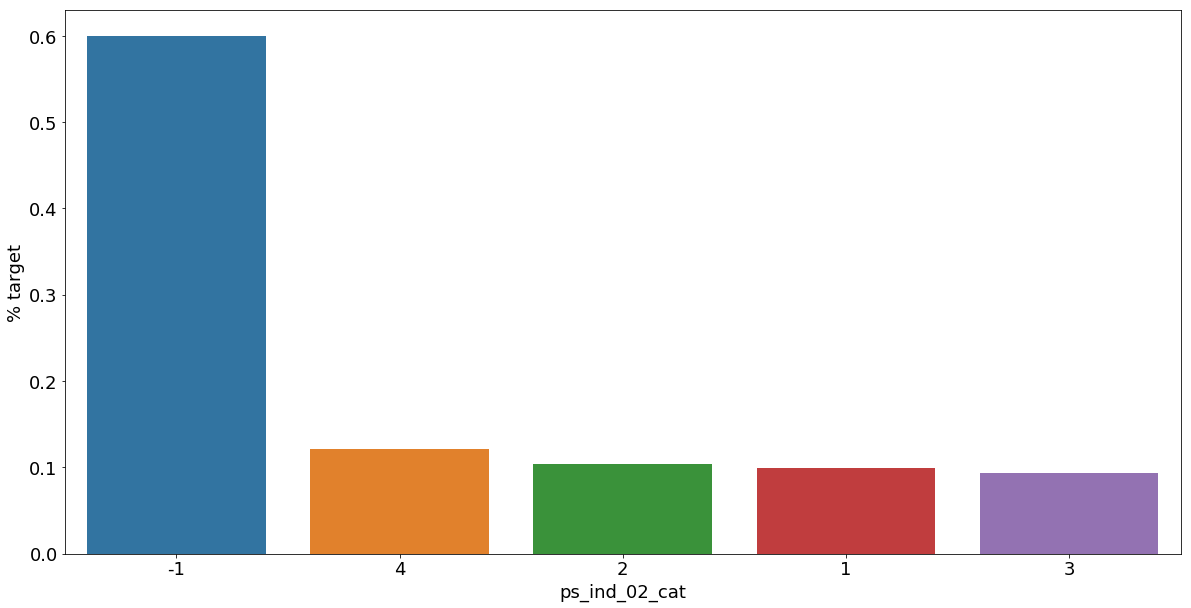

<Figure size 432x288 with 0 Axes>

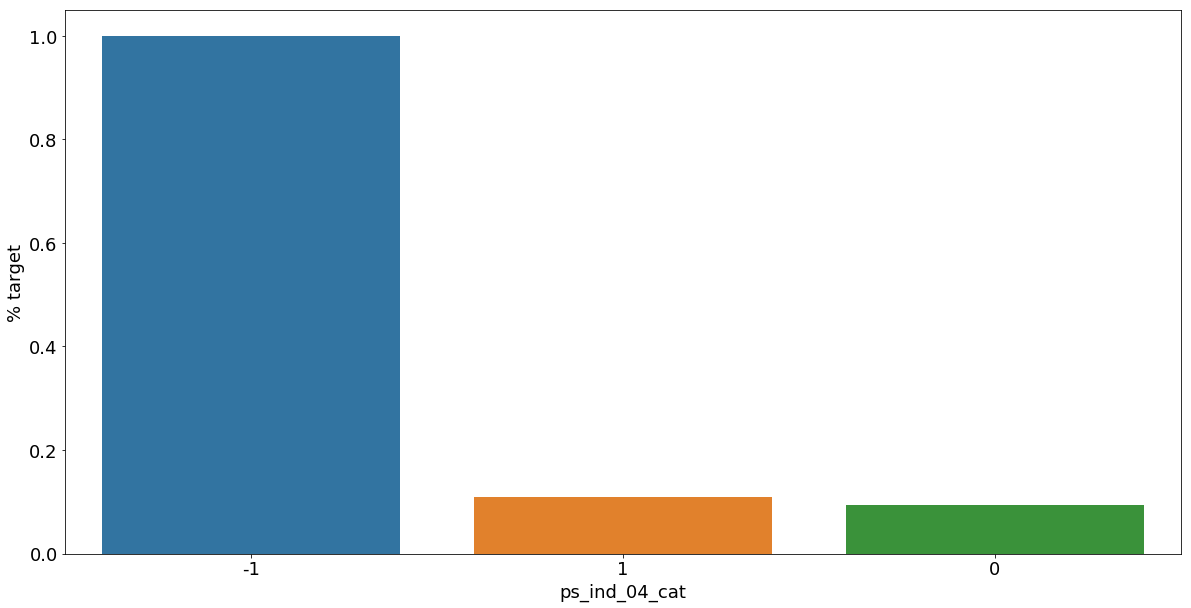

<Figure size 432x288 with 0 Axes>

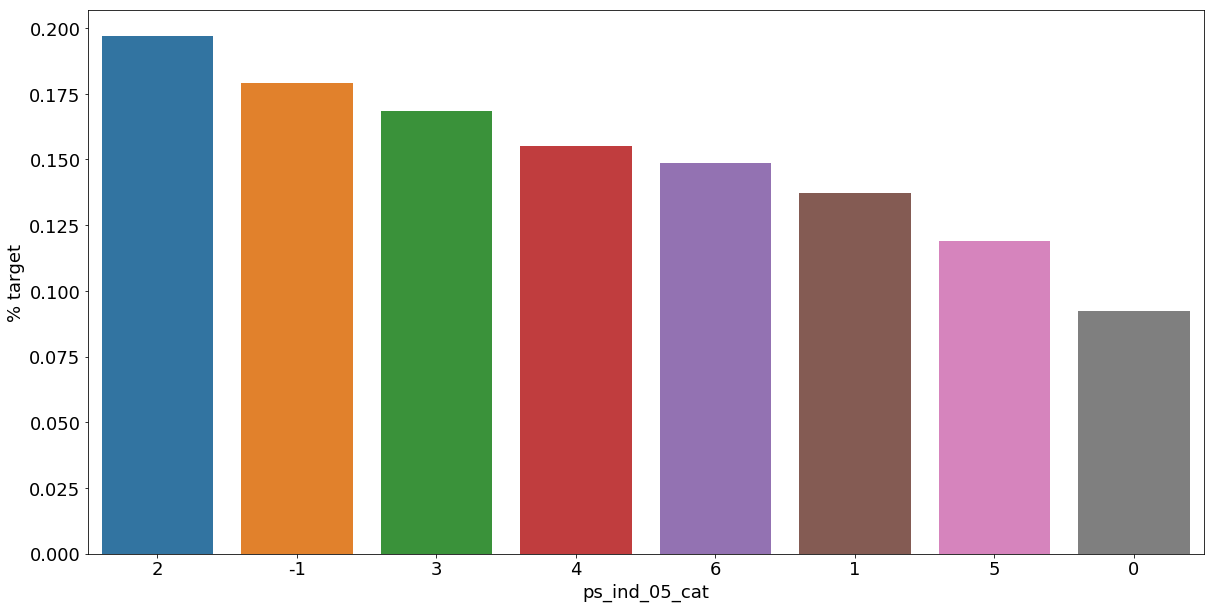

<Figure size 432x288 with 0 Axes>

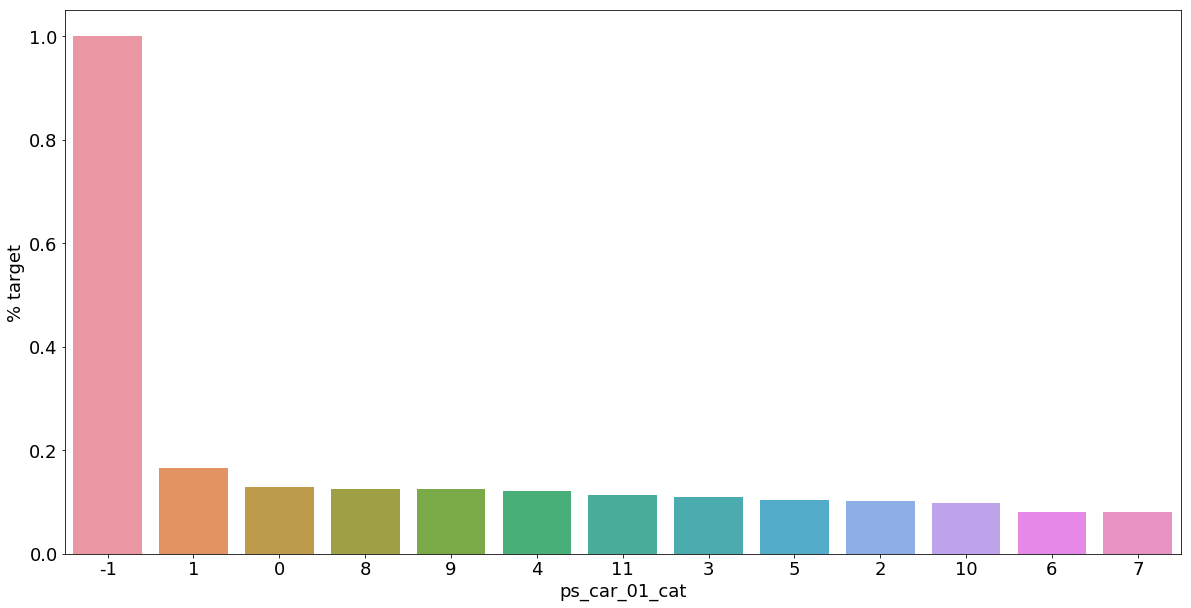

<Figure size 432x288 with 0 Axes>

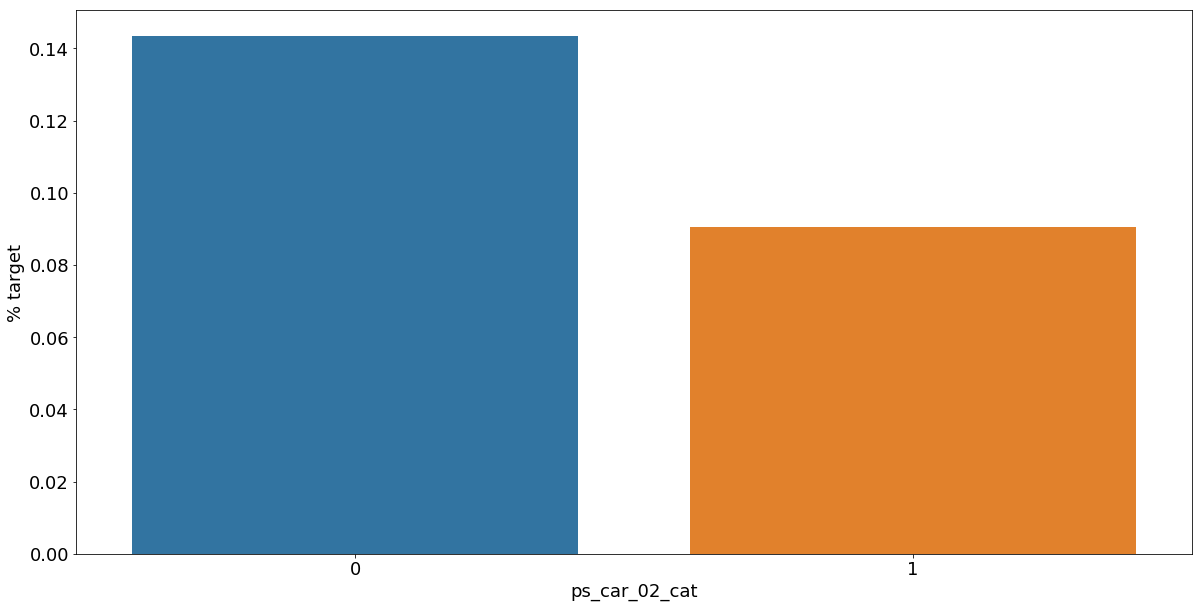

<Figure size 432x288 with 0 Axes>

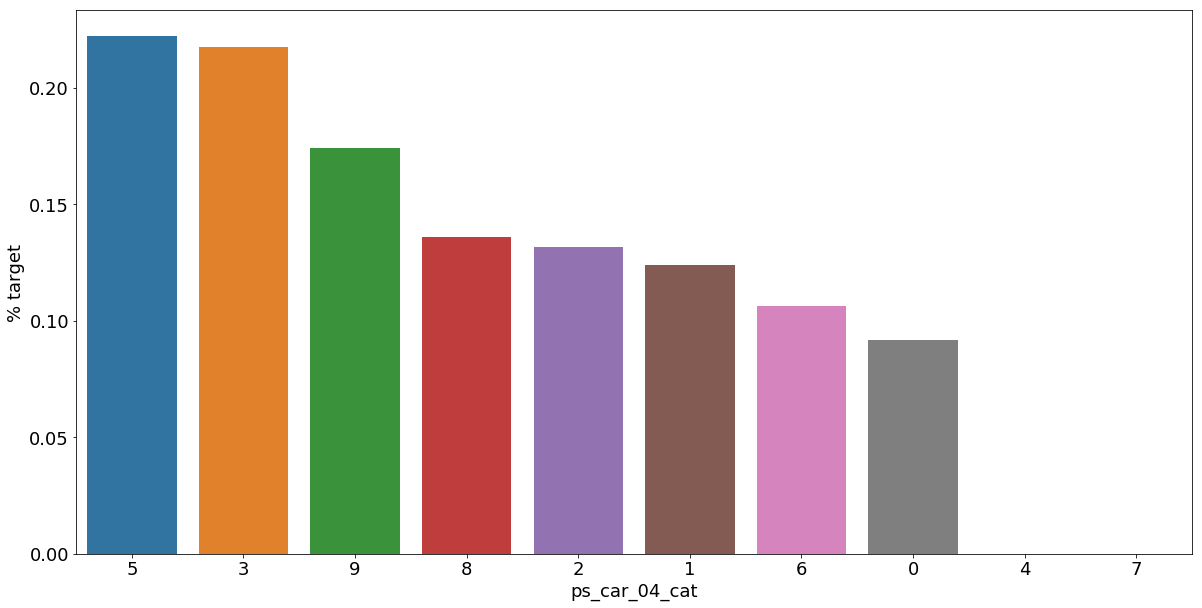

<Figure size 432x288 with 0 Axes>

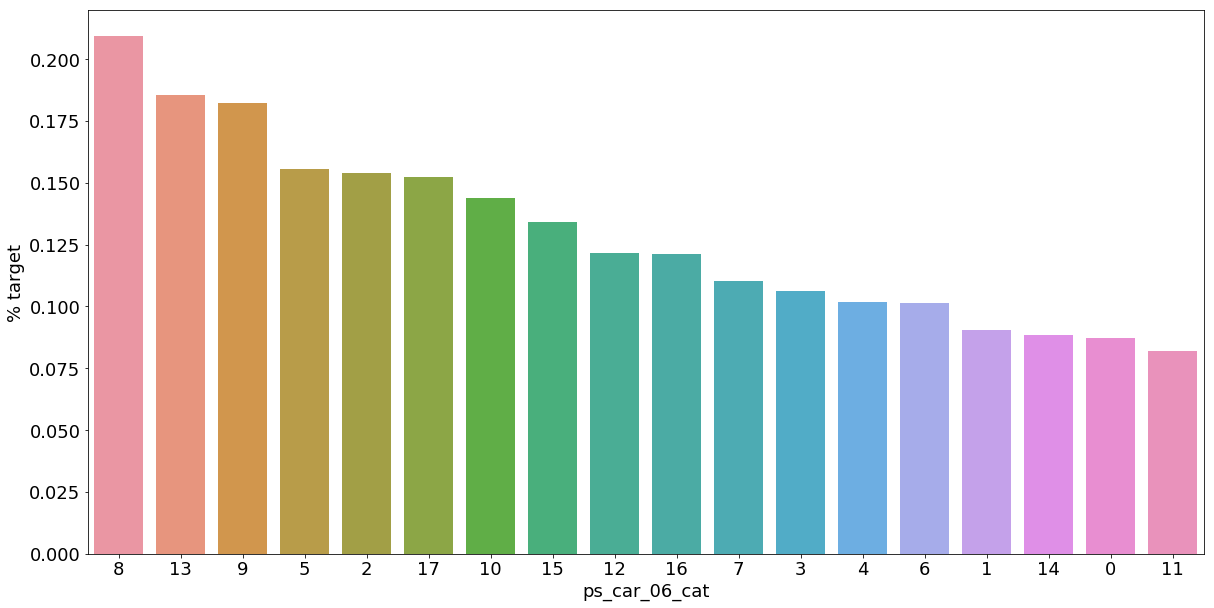

<Figure size 432x288 with 0 Axes>

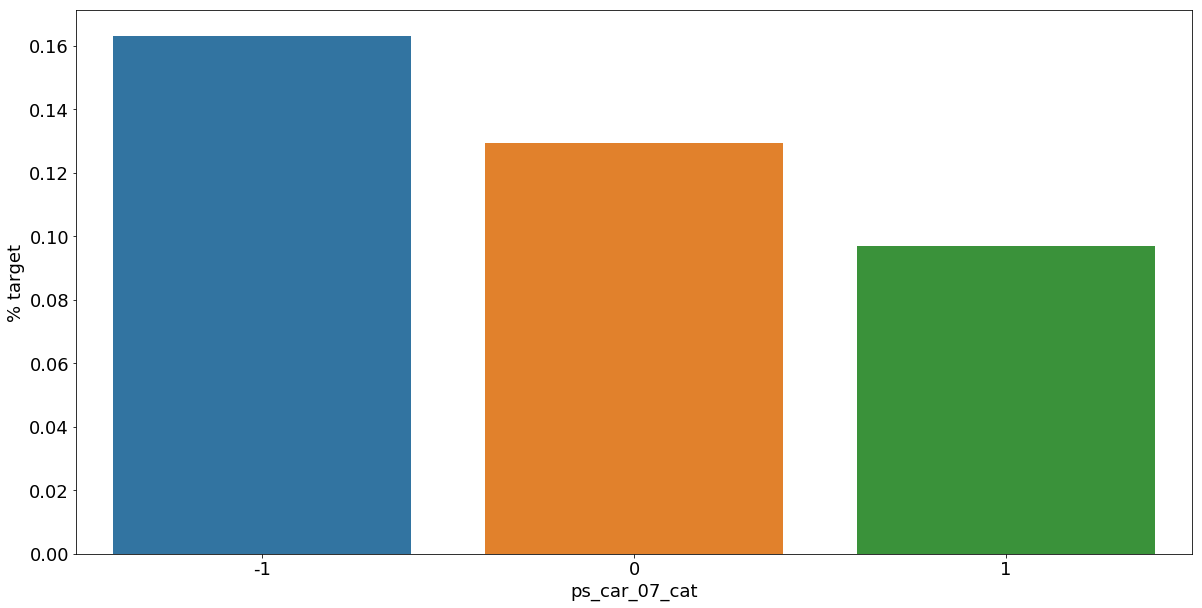

<Figure size 432x288 with 0 Axes>

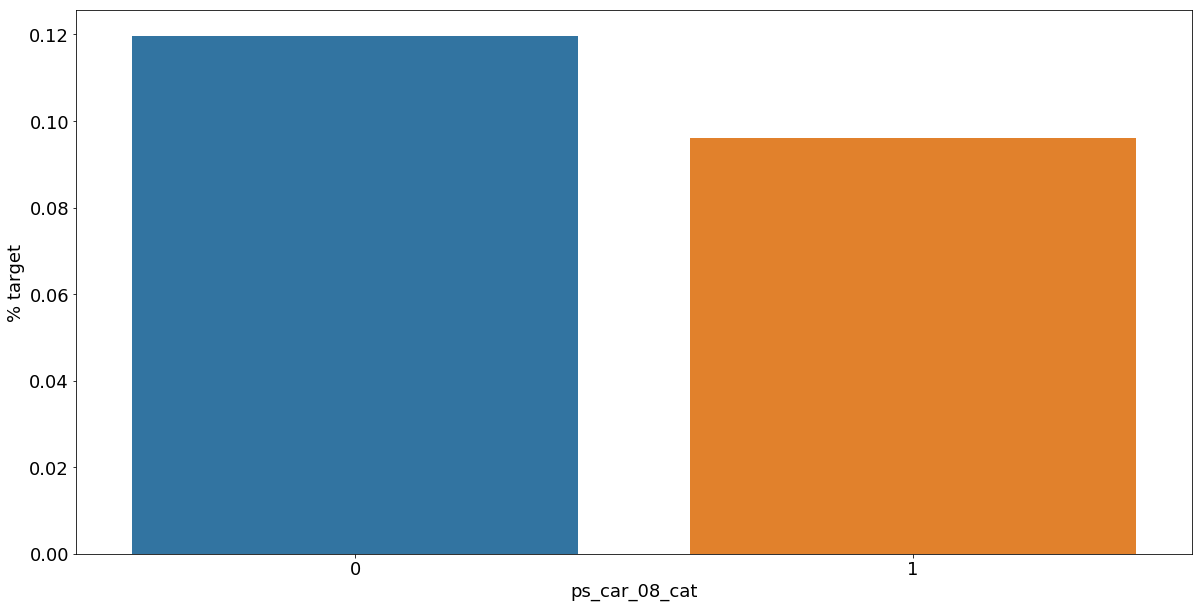

<Figure size 432x288 with 0 Axes>

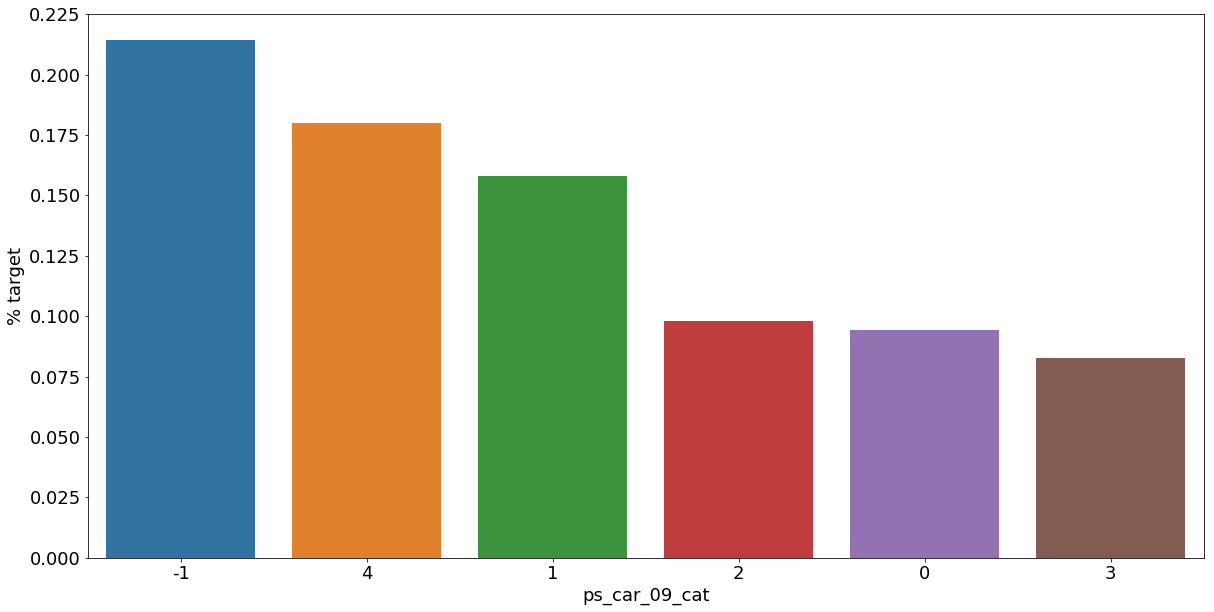

<Figure size 432x288 with 0 Axes>

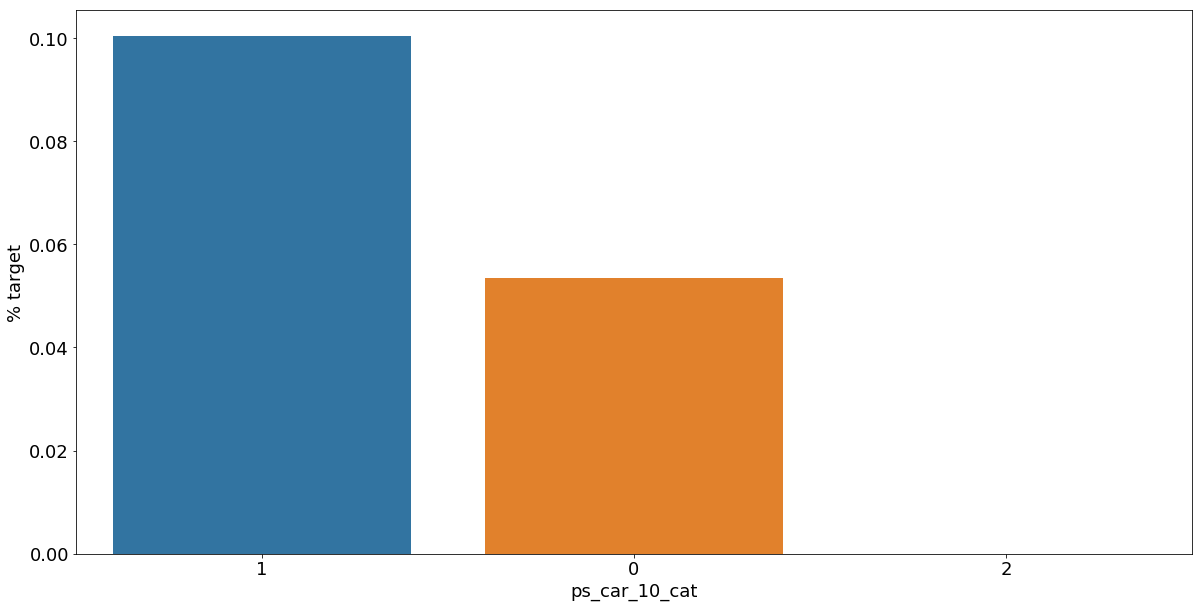

In [66]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index

for f in v:
    plt.figure()
    fig, ax = plt.subplots(figsize=(20,10))
    cat_perc = train[[f,'target']].groupby([f],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    sns.barplot(ax=ax, x=f, y='target', data=cat_perc, order=cat_perc[f])
    #타켓 평균으로 내림차순
    
    plt.ylabel('% target', fontsize=18)
    plt.xlabel(f, fontsize=18)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.show()

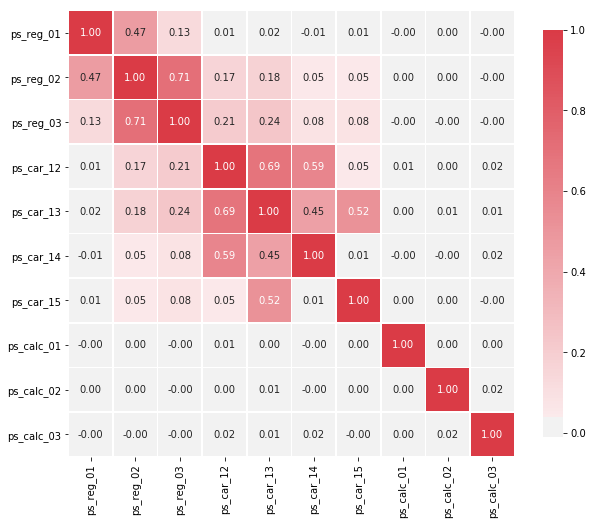

In [67]:
def corr_heatmap(v):
    correlations = train[v].corr()
    #interval인 컬럼들의 corr 상관관계
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, cmap=cmap, vmax=1.0, center=0, fmt='.2f',
               square=True, linewidths=.5,annot=True, cbar_kws={'shrink':.75})
    plt.show()
    
v = meta[(meta.level == 'interval') & (meta.keep)].index
corr_heatmap(v)

* 히트 맵은 제한된 수의 상관 관계 변수를 보여주기 때문에 각 상관 관계가 높은 변수를 개별적으로 확인해보는 절차가 필요하다.
* seaborn은 변수 사이의 (선형)관계를 시각화하는 몇 가지 편리한 플롯을 가지고 있다.

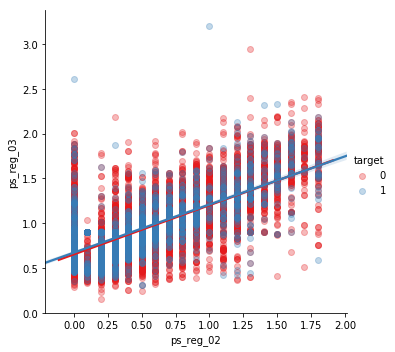

In [68]:
sns.lmplot(x='ps_reg_02', y='ps_reg_03', data=train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
#상관관계가 약 0.7로 짙은 ps_reg_02와 ps_reg_03의 선형 관계를 확인
plt.show()

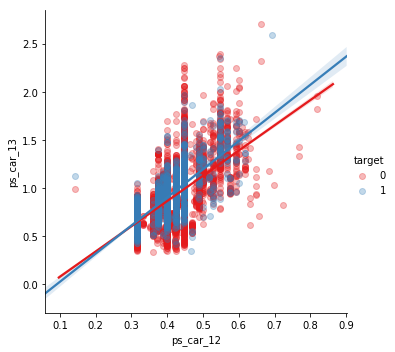

In [69]:
sns.lmplot(x='ps_car_12', y='ps_car_13', data=train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

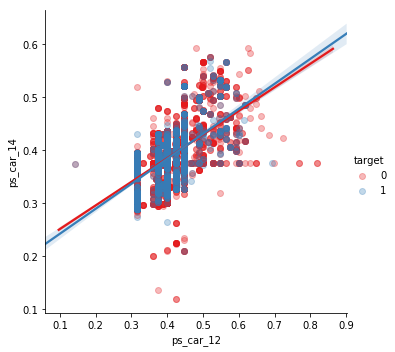

In [70]:
sns.lmplot(x='ps_car_12', y='ps_car_14', data=train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

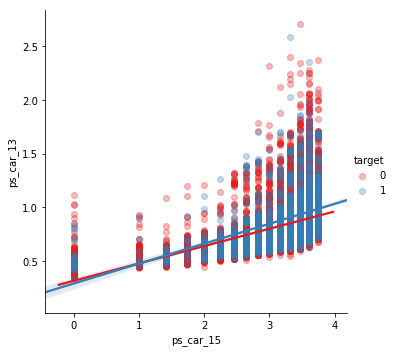

In [71]:
sns.lmplot(x='ps_car_15', y='ps_car_13', data=train, hue='target', palette='Set1', scatter_kws={'alpha':0.3})
plt.show()

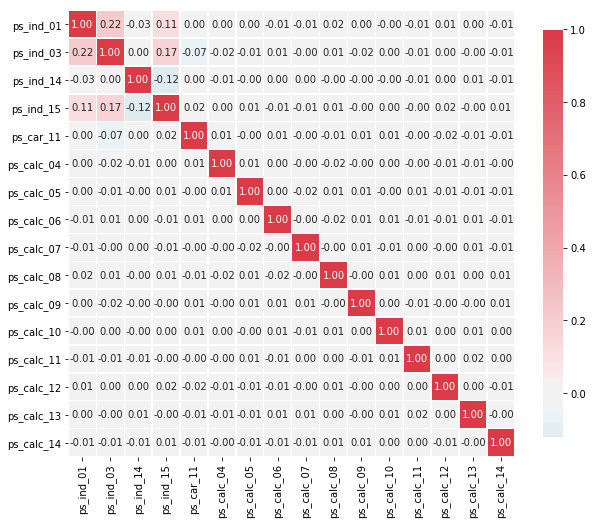

In [72]:
v = meta[(meta.level == 'ordinal') & (meta.keep)].index
corr_heatmap(v)

# 피처 엔지니어링

* 카테고리 값을 다루기 위해 더미 변수를 만들 수 있다.
* 첫 번째 더미 변수는 원래 변수의 범주에 대해 생성된 다른 더미 변수에서 파생될 수 있기 때문에 버린다.

In [73]:
v = meta[(meta.level == 'nominal') & (meta.keep)].index
print('Before dummification we have {} variables in train'.format(train.shape[1]))
train = pd.get_dummies(train, columns=v, drop_first=True)
#drop_first=True를 해줌으로써 첫 번째 더미 변수를 버린다.
print('After dummification we have {} variables in train'.format(train.shape[1]))

Before dummification we have 57 variables in train
After dummification we have 108 variables in train


* interaction 변수 만들기
* train데이터에 추가적인 상호 작용 변수를 넣어준다
* 컬럼을 엮어 고려 가능한 피처수를 생성한다.

In [74]:
v = meta[(meta.level == 'interval') & (meta.keep)].index
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
interactions = pd.DataFrame(data=poly.fit_transform(train[v]), columns=poly.get_feature_names(v))
#get_feature_names 메소드 덕분에 새로운 변수에 열 이름을 할당 할 수 있음
interactions.drop(v, axis=1, inplace=True)
#원래의 컬럼 제거
print('Before creating interactions we have {} variables in train'.format(train.shape[1]))
train = pd.concat([train, interactions], axis=1)
print('After creating interactions we have {} variables in train'.format(train.shape[1]))

Before creating interactions we have 108 variables in train
After creating interactions we have 163 variables in train


# 피처 선택

* 분산이 낮거나 0인 피처 제거
* VarianceThreshold는 기본적으로 분산이 0인 피처를 제거 할 수 있음
* 이전 단계에서 분산이 0인 피처가 없는 것을 확인했으므로 적용하진 않음

In [75]:
selector = VarianceThreshold(threshold=.01)
selector.fit(train.drop(['id', 'target'], axis=1)) 
#id와 target값을 제외하고 fit하는 것이 적절
f = np.vectorize(lambda x : not x) 
v = train.drop(['id', 'target'], axis=1).columns[f(selector.get_support())]
print('{} variables have too low variance.'.format(len(v)))
print('These variables are {}'.format(list(v)))

28 variables have too low variance.
These variables are ['ps_ind_10_bin', 'ps_ind_11_bin', 'ps_ind_12_bin', 'ps_ind_13_bin', 'ps_car_12', 'ps_car_14', 'ps_car_11_cat_te', 'ps_ind_05_cat_2', 'ps_ind_05_cat_5', 'ps_car_01_cat_1', 'ps_car_01_cat_2', 'ps_car_04_cat_3', 'ps_car_04_cat_4', 'ps_car_04_cat_5', 'ps_car_04_cat_6', 'ps_car_04_cat_7', 'ps_car_06_cat_2', 'ps_car_06_cat_5', 'ps_car_06_cat_8', 'ps_car_06_cat_12', 'ps_car_06_cat_16', 'ps_car_06_cat_17', 'ps_car_09_cat_4', 'ps_car_10_cat_1', 'ps_car_10_cat_2', 'ps_car_12^2', 'ps_car_12 ps_car_14', 'ps_car_14^2']


In [76]:
X_train = train.drop(['id', 'target'], axis=1)
y_train = train['target']

feat_labels = X_train.columns

rf = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

rf.fit(X_train, y_train)
importances = rf.feature_importances_
#RandomForestClassifier로 피처importances를 추출

indices = np.argsort(rf.feature_importances_)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30,feat_labels[indices[f]], importances[indices[f]]))

 1) ps_car_11_cat_te               0.022789
 2) ps_car_13^2                    0.016559
 3) ps_reg_03 ps_car_13            0.016459
 4) ps_car_13                      0.016456
 5) ps_car_12 ps_car_13            0.016442
 6) ps_car_13 ps_car_15            0.016142
 7) ps_reg_03 ps_car_12            0.016009
 8) ps_reg_01 ps_car_13            0.015949
 9) ps_reg_03 ps_car_14            0.015943
10) ps_car_13 ps_car_14            0.015748
11) ps_car_14 ps_car_15            0.015030
12) ps_reg_03 ps_car_15            0.014978
13) ps_reg_01 ps_car_14            0.014623
14) ps_car_13 ps_calc_02           0.014491
15) ps_reg_03^2                    0.014361
16) ps_reg_03                      0.014283
17) ps_car_13 ps_calc_03           0.014201
18) ps_reg_01 ps_reg_03            0.013946
19) ps_car_13 ps_calc_01           0.013927
20) ps_reg_02 ps_car_13            0.013768
21) ps_car_12 ps_car_14            0.013750
22) ps_reg_03 ps_calc_03           0.013629
23) ps_car_14 ps_calc_02        

In [77]:
sfm = SelectFromModel(rf, threshold='median', prefit=True)
#RandomForestClassifier에서 추출한 피처importances에 따라 SelectFromModel을 사용하여 피처를 상위 50%만 선택
print('Number of features before selection : {}'.format(X_train.shape[1]))
n_features = sfm.transform(X_train).shape[1]
print('Number of features after selection : {}'.format(n_features))
selected_vars = list(feat_labels[sfm.get_support()])

Number of features before selection : 161
Number of features after selection : 81


In [78]:
train = train[selected_vars + ['target']]

# 피처 스케일링

In [79]:
scaler = StandardScaler()
scaler.fit_transform(train.drop(['target'], axis=1))

array([[ 0.04197132, -0.52983102,  0.77379227, ..., -1.02415405,
        -0.61483475,  1.31481328],
       [-0.96435208, -0.89994545,  0.77379227, ..., -0.91211744,
        -0.81284621, -0.91761277],
       [-0.46119038,  0.58051226,  0.77379227, ...,  1.96348911,
        -1.01085766, -1.06644117],
       ...,
       [-0.46119038,  0.21039784, -0.63686676, ..., -1.06149959,
        -1.01085766,  0.27301446],
       [ 1.55145642, -0.15971659, -0.63686676, ..., -0.46397096,
         0.77124544,  1.947334  ],
       [-0.46119038,  0.21039784,  1.05592407, ...,  0.76843185,
        -0.31781757, -0.91761277]])

# 출처

In [ ]:
'''
https://www.kaggle.com/bertcarremans/data-preparation-exploration
'''